<center>
In God We Trust
</center>

# CE417: Artificial Intelligence

Dr. Mahdiyeh Soleymani Baghshah, Associate Professor

Computer Engineering Department,
Sharif University of Technology,
Tehran, Tehran, Iran


# MNIST Autoencoder (20 Points)

Corresponding TA: Aryan Ahadinia

In this problem, we want to train an autoencoder. Autoencoder is a type of neural network which is used for unsupervised tasks. Figure below is showing a simple autoencoder.

<center>
<img src="./assets/autoencoder.png" style="width: 50%">
</center>

We want to train a neural network which get a noisy image as input and denoise it in the output. We focus on MNIST dataset. MNIST is a dataset containing 60000 images of hand-written digits. We artificially add a random noise to images and then we train our network to get the noisy image as input and give the cleared image in the output.

<center>
<img src="./assets/desc.png" style="width: 50%">
</center>


If you have an nVidia CUDA-compatible GPU, you can proceed to install CUDA and a CUDA-compatible pytorch versions. You can also use Google Colaboratory or Kaggle.
 

In [ ]:
%pip install numpy
%pip install tqdm
%pip install matplotlib
%pip install torch torchvision torchaudio


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn

from tqdm import tqdm


In cell below, we load our data.

In [10]:
transform = transforms.ToTensor() # changed this because the error was too high with this

mnist_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
mnist_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)


Now we want to wrap our dataset in torch datasets. Each item in our dataset must contain tree entities, the noisy image, the original image and the label. Apply a noise on the original image regarding the noise factor.

Complete cell below. (3 Points)


In [11]:
class NoisyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, noise_factor=0.5):
        self.noise_factor = noise_factor
        self.dataset = dataset
        self.noisy_images, self.original_images, self.labels = [], [], []
        self.length = len(self.dataset)
        for data in range(0, self.length):
          original, label = dataset[data]
          self.original_images.append(original)
          self.labels.append(label)
          self.noisy_images.append(np.clip(original + noise_factor * torch.randn(*original.shape), 0, 1))

    def __getitem__(self, index):
        return (self.noisy_images[index], self.original_images[index], self.labels[index])

    def __len__(self):
        return len(self.labels)


In [13]:
noisy_mnist_train = NoisyDataset(mnist_train, 0.6)
noisy_mnist_test = NoisyDataset(mnist_test, 0.6)
mnist_train_loader = torch.utils.data.DataLoader(
    noisy_mnist_train, batch_size=60, shuffle=True
)
mnist_test_loader = torch.utils.data.DataLoader(
    noisy_mnist_test, batch_size=60, shuffle=True
)


Now, design a proper network architecture. Complete cell below. (6 Points)

In [14]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2) 
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)
        
    def forward(self, img):
        return F.sigmoid(self.conv_out(F.relu(self.t_conv3(F.relu(self.t_conv2(F.relu(self.t_conv1(self.pool(F.relu(self.conv3(self.pool(F.relu(self.conv2(self.pool(F.relu(self.conv1(img)))))))))))))))))


Now, train the network. We recommend MSE Loss and Adam Optimizer. (6 Points)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
AutoEncoder = Net().to(device)
MSELoss = nn.MSELoss()

In [17]:
AdamOptimizer = torch.optim.Adam(AutoEncoder.parameters(), lr=0.001)
for epoch in range(0, 30):  #30 epochs for training
  for noisy, original, label in tqdm(mnist_train_loader):
    result = AutoEncoder(noisy)
    AdamOptimizer.zero_grad()
    loss = MSELoss(result, original)
    loss.backward()
    AdamOptimizer.step()

100%|██████████| 1000/1000 [01:37<00:00, 10.27it/s]


Now, plot the results like figure above. (5 Points)

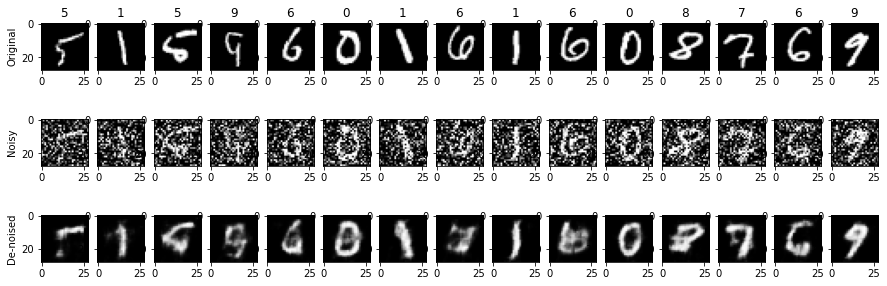

In [18]:
fig, axes = plt.subplots(3,15,figsize=(15,5))
axes[0,0].set_ylabel("Original")
axes[1,0].set_ylabel("Noisy")
axes[2,0].set_ylabel("De-noised")
import random

random_figs = random.sample(range(1, 100), 15)
count = 0
for i in random_figs:
  noisy, original, label = noisy_mnist_test[i]
  noisy_fig = noisy.view(28, 28).type(torch.FloatTensor)
  original_fig = original.view(28, 28).type(torch.FloatTensor)
  denoised = AutoEncoder(noisy)
  denoised_fig = denoised.view(28, 28).type(torch.FloatTensor).detach()
  axes[0, count].set_title(label)
  axes[0, count].imshow(original_fig, cmap='gray')
  axes[1, count].imshow(noisy_fig, cmap='gray')
  axes[2, count].imshow(denoised_fig, cmap='gray')
  count += 1